In [26]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_fscore_support

from collections import Counter

from keras.models import Model
from keras.layers import (
    Input, Embedding, Bidirectional, LSTM,
    Conv1D, GlobalMaxPooling1D, Dense, Dropout, concatenate
)
from keras.optimizers import Adam
from keras.callbacks import Callback

In [31]:
# -----------------------------
# Step 1: Load & Concatenate Data
# -----------------------------
paths = [
    '../data/goemotions/goemotions_1.csv',
    '../data/goemotions/goemotions_2.csv',
    '../data/goemotions/goemotions_3.csv'
]
# Read and concatenate all parts
dfs = [pd.read_csv(p) for p in paths]
df = pd.concat(dfs, ignore_index=True)

In [32]:
# -----------------------------
# Step 2: Text Cleaning Function
# -----------------------------
def clean_text(text):
    """
    Lowercase, remove HTML tags, strip non-alphanumeric characters,
    and normalize whitespace.
    """
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)            # Remove HTML tags
    text = re.sub(r'[^a-z0-9\s]', '', text)      # Remove punctuation/special chars
    text = re.sub(r'\s+', ' ', text).strip()     # Collapse whitespace
    return text

# Apply cleaning
df['clean_text'] = df['text'].astype(str).apply(clean_text)

In [33]:
# -----------------------------
# Step 3: Train/Val/Test Split
# -----------------------------
# 80% train, 10% validation, 10% test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df  = train_test_split(temp_df, test_size=0.5, random_state=42)

In [34]:
# -----------------------------
# Step 4: Build Vocabulary & Tokenize
# -----------------------------
max_words = 20000    # Vocabulary size
max_len   = 128      # Sequence length

# Count word frequencies on training set
counter = Counter()
for text in train_df['clean_text']:
    counter.update(text.split())

# Keep top (max_words - 1) words; reserve 0=PAD, 1=OOV
vocab = [w for w, _ in counter.most_common(max_words-1)]
word_index = {w: i+2 for i, w in enumerate(vocab)}

def text_to_seq(text):
    """Convert cleaned text into a list of integer token IDs."""
    return [word_index.get(w, 1) for w in text.split()]  # 1 = OOV

def pad_seq(seq, max_len):
    """Truncate or pad sequence with zeros up to max_len."""
    if len(seq) > max_len:
        return seq[:max_len]
    return seq + [0] * (max_len - len(seq))

# Convert and pad all splits
train_seq = np.array([pad_seq(text_to_seq(t), max_len) for t in train_df['clean_text']], dtype=np.int16)
val_seq   = np.array([pad_seq(text_to_seq(t), max_len) for t in val_df['clean_text']],   dtype=np.int16)
test_seq  = np.array([pad_seq(text_to_seq(t), max_len) for t in test_df['clean_text']],  dtype=np.int16)

In [35]:
# -----------------------------
# Step 5: Prepare Multi-Label Targets
# -----------------------------
# Identify emotion columns (exclude metadata fields)
exclude = {'text','id','author','subreddit','link_id','parent_id','created_utc','rater_id','example_very_unclear'}
label_cols = [c for c in df.columns if c not in exclude and c != 'clean_text']

train_labels = train_df[label_cols].values
val_labels   = val_df[label_cols].values
test_labels  = test_df[label_cols].values

num_classes = len(label_cols)
vocab_size  = max_words + 2  # accounting for PAD and OOV

In [36]:
# -----------------------------
# Step 6: Custom Callback for Macro-F1
# -----------------------------
class F1Metrics(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.val_seq, self.val_labels = validation_data
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        # Predict and binarize at threshold 0.5
        preds = (self.model.predict(self.val_seq) > 0.5).astype(int)
        # Compute macro-F1
        f1 = f1_score(self.val_labels, preds, average='macro')
        self.val_f1s.append(f1)
        print(f" — val_macro_f1: {f1:.4f}")

In [37]:
# -----------------------------
# Step 7: Define Model Architectures
# -----------------------------
def build_lstm_model(vocab_size, max_len, num_classes,
                     emb_dim=100, lstm_units=128):
    """
    Bi-directional LSTM model:
    Embedding -> Bi-LSTM -> Dropout -> Dense(sigmoid)
    """
    inp = Input(shape=(max_len,))
    x   = Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len)(inp)
    x   = Bidirectional(LSTM(lstm_units))(x)
    x   = Dropout(0.5)(x)
    out = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inp, out)
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(1e-3),
        metrics=['binary_accuracy']
    )
    return model

def build_cnn_model(vocab_size, max_len, num_classes,
                    emb_dim=100, filters=64, kernel_sizes=[3,4,5]):
    """
    Multi-filter 1D-CNN:
    Embedding -> Conv1D(each size) -> GlobalMaxPool -> Concat -> Dropout -> Dense(sigmoid)
    """
    inp = Input(shape=(max_len,))
    x   = Embedding(vocab_size, emb_dim, input_length=max_len)(inp)
    convs = []
    for k in kernel_sizes:
        c = Conv1D(filters, k, activation='relu')(x)
        c = GlobalMaxPooling1D()(c)
        convs.append(c)
    x   = concatenate(convs)
    x   = Dropout(0.5)(x)
    out = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inp, out)
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(1e-3),
        metrics=['binary_accuracy']
    )
    return model

# ============================================================
# Callback-Bundle: EarlyStopping + ReduceLROnPlateau
# ============================================================
common_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',        # beobachte Val-Loss
        patience=3,                # 3 Epochen ohne Verbesserung → Stop
        min_delta=1e-4,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,                # Lernrate halbieren
        patience=2,                # wenn 2 Epochen Plateau
        verbose=1,
        min_lr=1e-6
    )
]

In [38]:
# -----------------------------
# Step 8: Train Models
# -----------------------------
batch_size = 32
epochs     = 20          # ruhig höher; EarlyStopping kürzt ab

# ─── Bi-LSTM ────────────────────────────────────────────────
lstm_model = build_lstm_model(vocab_size, max_len, num_classes)
f1_cb_lstm = F1Metrics((val_seq, val_labels))

history_lstm = lstm_model.fit(
    train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[f1_cb_lstm, *common_callbacks],   # ★ hier ergänzt
    verbose=2
)

# ─── 1D-CNN ────────────────────────────────────────────────
cnn_model = build_cnn_model(vocab_size, max_len, num_classes)
f1_cb_cnn = F1Metrics((val_seq, val_labels))

history_cnn = cnn_model.fit(
    train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[f1_cb_cnn, *common_callbacks],   # ★ hier ergänzt
    verbose=2
)

/Users/leander/Desktop/advanced pa/advanced-topics-predictive-group-j/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
661/661 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step
 — val_macro_f1: 0.1172
5281/5281 - 391s - 74ms/step - binary_accuracy: 0.9593 - loss: 0.1380 - val_binary_accuracy: 0.9609 - val_loss: 0.1224
Epoch 2/5
661/661 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step
 — val_macro_f1: 0.1568
5281/5281 - 493s - 93ms/step - binary_accuracy: 0.9610 - loss: 0.1217 - val_binary_accuracy: 0.9613 - val_loss: 0.1186
Epoch 3/5
661/661 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step
 — val_macro_f1: 0.1707
5281/5281 - 485s - 92ms/step - binary_accuracy: 0.9617 - loss: 0.1166 - val_binary_accuracy: 0.9613 - val_loss: 0.1174
Epoch 4/5
661/661 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step
 — val_macro_f1: 0.1918
5281/5281 - 610s - 115ms/step - binary_accuracy: 0.9622 - loss: 0.1129 - val_binary_accuracy: 0.9613 - val_loss: 0.1177
Epoch 5/5
661/661 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step
 — val_macro_f1: 0.1834
5281/5281 - 445s - 84ms/step - binary_accuracy: 0.9627 - loss: 0.1102 - val_binary_accuracy: 0.9612 - val_loss: 0.1183
Epoch 1/5


/Users/leander/Desktop/advanced pa/advanced-topics-predictive-group-j/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


661/661 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
 — val_macro_f1: 0.1268
5281/5281 - 1974s - 374ms/step - binary_accuracy: 0.9589 - loss: 0.1398 - val_binary_accuracy: 0.9609 - val_loss: 0.1242
Epoch 2/5
661/661 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
 — val_macro_f1: 0.1629
5281/5281 - 1040s - 197ms/step - binary_accuracy: 0.9604 - loss: 0.1267 - val_binary_accuracy: 0.9611 - val_loss: 0.1215
Epoch 3/5
661/661 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
 — val_macro_f1: 0.1722
5281/5281 - 1816s - 344ms/step - binary_accuracy: 0.9610 - loss: 0.1224 - val_binary_accuracy: 0.9610 - val_loss: 0.1210
Epoch 4/5
661/661 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
 — val_macro_f1: 0.1728
5281/5281 - 70s - 13ms/step - binary_accuracy: 0.9615 - loss: 0.1190 - val_binary_accuracy: 0.9611 - val_loss: 0.1217
Epoch 5/5
661/661 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
 — val_macro_f1: 0.1906
5281/5281 - 78s - 15ms/step - binary_accuracy: 0.9619 - loss: 0.1166 - val_binary_accuracy: 0.9609 - val_loss: 0.1223


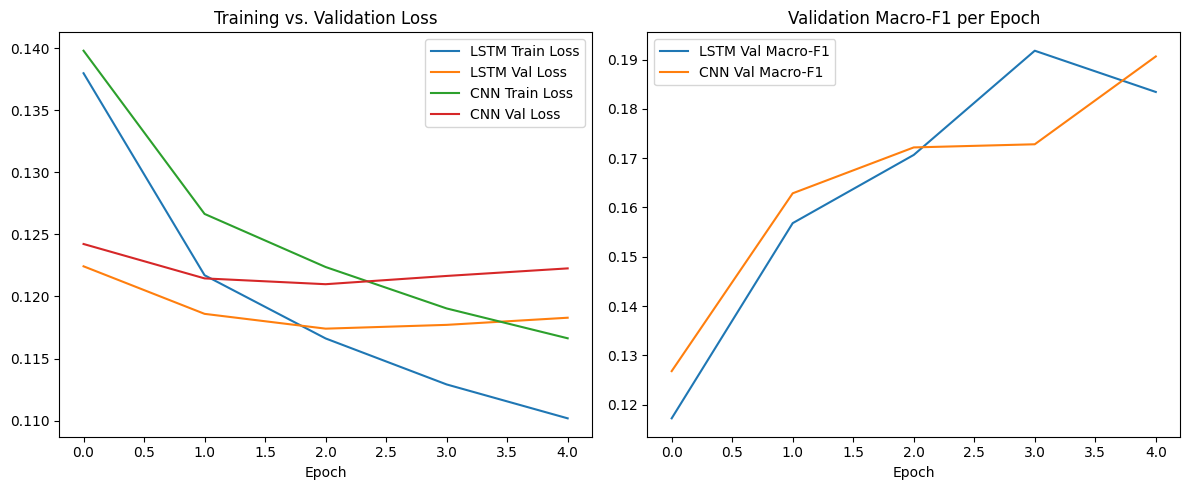

In [39]:
# -----------------------------
# Step 9: Plot Training Curves
# -----------------------------
plt.figure(figsize=(12,5))

# Plot loss curves
plt.subplot(1,2,1)
plt.plot(history_lstm.history['loss'],   label='LSTM Train Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Val Loss')
plt.plot(history_cnn.history['loss'],    label='CNN Train Loss')
plt.plot(history_cnn.history['val_loss'],   label='CNN Val Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot validation Macro-F1
plt.subplot(1,2,2)
plt.plot(f1_cb_lstm.val_f1s, label='LSTM Val Macro-F1')
plt.plot(f1_cb_cnn.val_f1s,   label='CNN Val Macro-F1')
plt.title('Validation Macro-F1 per Epoch')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
# -----------------------------
# Step 10: Final Evaluation on Test Set
# -----------------------------
for name, model in [('Bi-LSTM', lstm_model), ('1D-CNN', cnn_model)]:
    preds = (model.predict(test_seq) > 0.5).astype(int)
    macro_f1 = f1_score(test_labels, preds, average='macro')
    micro_f1 = f1_score(test_labels, preds, average='micro')
    p, r, f, _ = precision_recall_fscore_support(
        test_labels, preds, average=None, zero_division=0
    )
    print(f"\n{name} — Test Macro-F1: {macro_f1:.4f}, Micro-F1: {micro_f1:.4f}")
    # Display metrics for first 5 emotions
    print("Sample per-emotion (first 5):")
    for i in range(5):
        print(f"  {label_cols[i]}: P={p[i]:.2f}, R={r[i]:.2f}, F1={f[i]:.2f}")

661/661 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step

Bi-LSTM — Test Macro-F1: 0.1760, Micro-F1: 0.2786
Sample per-emotion (first 5):
  admiration: P=0.68, R=0.40, F1=0.51
  amusement: P=0.59, R=0.25, F1=0.35
  anger: P=0.57, R=0.10, F1=0.16
  annoyance: P=1.00, R=0.00, F1=0.00
  approval: P=0.61, R=0.04, F1=0.08
661/661 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

1D-CNN — Test Macro-F1: 0.1841, Micro-F1: 0.2935
Sample per-emotion (first 5):
  admiration: P=0.69, R=0.35, F1=0.46
  amusement: P=0.60, R=0.32, F1=0.42
  anger: P=0.49, R=0.06, F1=0.11
  annoyance: P=0.42, R=0.01, F1=0.02
  approval: P=0.61, R=0.04, F1=0.07
